# Counterfactual functionality of [polis.basis.ai](http://polis.basis.ai/)

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns

from cities.queries.causal_insight_slim import CausalInsightSlim
from cities.utils.data_grabber import (
    DataGrabber,
    find_repo_root,
    list_available_features,
    list_interventions,
    list_outcomes,
    list_tensed_features,
)

root = find_repo_root()

Suppose you're interested in the impact of the Department of Commerce funding on the unemployment rate. Assume further that you're particularly interested in the fate of Imperial County, CA and what this county has potentially to gain from such funding. Say we want to estimate the causal role such a funding could have had if received in 2016. (this is because we can only fairly reliably estimate three years ahead, and we want to end the estimation period before the Covid pandemic, to avoid complications in the discussion of the result). Since you know it is unreasonable to expect such funding to have immediate impact, you allow for a one year of "grace period" and look at the outcome in 2018. The first thing you can you is load the data:

In [2]:
CausalInsight = CausalInsightSlim  # hacky way of avoiding isort complaining

outcome = "unemployment_rate"
intervention = "spending_commerce"
forward_shift = 2

dg = DataGrabber()
dg.get_features_wide([outcome, intervention])

display(dg.wide[intervention].head(), dg.wide[outcome].head())

sorted = dg.wide[outcome].sort_values(by="2016", ascending=False)
display(sorted.head(10))

,GeoFIPS,GeoName,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,1001,"Autauga, AL",0.0,0.0,0.0,0.0,0.0,0.0,0.0,2364930.0,0.0,0.0,0.0,0.0
1,1003,"Baldwin, AL",0.0,1274298.0,0.0,186580.0,105434.0,105434.0,846583.0,0.0,1589502.0,50000.0,0.0,800000.0
2,1005,"Barbour, AL",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1994425.0
3,1007,"Bibb, AL",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1009,"Blount, AL",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,GeoFIPS,GeoName,1990,1991,1992,1993,1994,1995,1996,1997,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,1001,"Autauga County, AL",6.5,6.8,6.5,5.9,5.0,5.6,3.9,3.9,...,6.3,5.8,5.2,5.1,4.0,3.6,2.9,5.3,2.8,2.3
1,1003,"Baldwin County, AL",5.3,5.5,6.3,5.9,4.8,4.7,4.4,3.5,...,6.7,6.1,5.6,5.4,4.2,3.6,2.9,6.1,2.9,2.4
2,1005,"Barbour County, AL",7.9,8.7,10.7,10.0,6.4,8.2,9.5,7.3,...,10.4,10.5,8.9,8.4,6.0,5.1,4.0,7.7,5.5,4.1
3,1007,"Bibb County, AL",9.2,11.8,11.1,11.5,7.7,6.5,7.1,7.4,...,8.0,7.2,6.7,6.5,4.5,4.0,3.3,7.3,3.4,2.5
4,1009,"Blount County, AL",6.4,5.8,6.2,5.2,4.2,4.4,3.3,3.0,...,6.4,6.1,5.4,5.4,4.1,3.5,2.8,4.5,2.4,2.2


,GeoFIPS,GeoName,1990,1991,1992,1993,1994,1995,1996,1997,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
190,6025,"Imperial County, CA",25.4,26.3,30.9,29.4,26.5,29.2,30.1,26.9,...,25.3,24.3,24.6,24.2,19.7,18.8,20.7,22.6,17.5,14.7
1058,21153,"Magoffin County, KY",15.5,18.0,16.1,15.4,13.7,15.2,14.6,13.9,...,17.4,13.9,15.6,19.6,16.0,12.6,10.5,15.6,11.5,10.5
102,4027,"Yuma County, AZ",20.6,20.9,26.6,27.9,31.3,29.5,30.6,27.5,...,25.6,22.9,21.8,19.1,17.2,16.9,16.7,17.1,13.1,12.5
87,2290,"Yukon-Koyukuk Census Area, AK",14.6,16.1,17.7,15.2,16.2,17.5,17.1,14.2,...,18.4,18.7,17.8,17.2,16.6,13.7,13.1,12.7,12.3,7.9
183,6011,"Colusa County, CA",14.2,18.1,21.7,21.7,19.2,19.7,20.1,19.0,...,19.1,17.6,15.5,15.6,14.3,13.2,12.9,16.4,12.5,11.6
84,2188,"Northwest Arctic Borough, AK",14.9,15.7,20.2,17.0,15.5,16.3,17.6,14.3,...,16.5,16.8,15.5,15.4,15.2,12.8,13.0,12.7,11.5,9.0
1414,28063,"Jefferson County, MS",22.9,28.4,20.9,17.8,17.8,15.5,15.3,15.7,...,19.2,16.3,15.1,15.2,15.0,13.4,15.9,18.2,15.8,13.0
1793,35029,"Luna County, NM",13.1,15.1,16.7,16.0,21.0,24.8,26.9,25.7,...,18.9,17.9,17.5,14.6,13.9,11.8,12.3,15.4,15.3,9.9
65,1131,"Wilcox County, AL",12.5,15.6,17.9,17.5,15.3,15.6,14.1,14.0,...,19.5,16.8,14.7,14.5,11.7,9.5,7.5,15.9,10.5,7.8
1410,28055,"Issaquena County, MS",11.9,13.4,12.9,13.5,14.8,16.1,17.9,14.5,...,20.4,17.6,17.2,14.3,12.2,9.2,12.2,8.9,8.9,7.3


Your first stab might be to select those counties which received no funding and compare them to those that receive a decent amount thereof, say above $1B. You visualize the comparison using a boxplot. 

In [3]:
int_data = dg.wide[intervention]["2016"]
out_data = dg.wide[outcome]["2018"]

unfunded_mask = int_data <= 0
moderately_funded_mask = int_data > 1 * 1e8
unfunded_data = out_data[unfunded_mask]

unfunded_fips_6025_mask = dg.wide[outcome]["GeoFIPS"][unfunded_mask] == 6025
moderately_data = out_data[moderately_funded_mask]
false_array = np.tile(False, len(moderately_data))

df = pd.DataFrame(
    {
        "Group": ["no funding"] * len(unfunded_data)
        + ["$1B < funding"] * len(moderately_data),
        "out_data": np.concatenate([unfunded_data, moderately_data]),
        "Imperial County, CA": np.concatenate([unfunded_fips_6025_mask, false_array]),
    }
)


fig = px.box(
    df,
    x="Group",
    y="out_data",
    points="all",
    color="Imperial County, CA",
    title="The unfunded vs. the funded (2016 vs. 2018)",
)
mean_unfunded = unfunded_data.mean()
mean_moderately = moderately_data.mean()
fig.add_annotation(
    x=0.3, y=mean_unfunded, text=f"Mean: {mean_unfunded:.2f}", showarrow=False
)
fig.add_annotation(
    x=0.18,
    y=18,
    text="Imperial County, CA",
    font=dict(size=10, color="red"),
    showarrow=False,
)
fig.add_annotation(
    x=1.3, y=mean_moderately, text=f"Mean: {mean_moderately:.2f}", showarrow=False
)
fig.update_layout(template="presentation")
fig.update_layout(showlegend=False)
fig.show()

You also vaguely recall from your stats class that you might try to quantify this impact using a linear model, so this is what you try to do:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


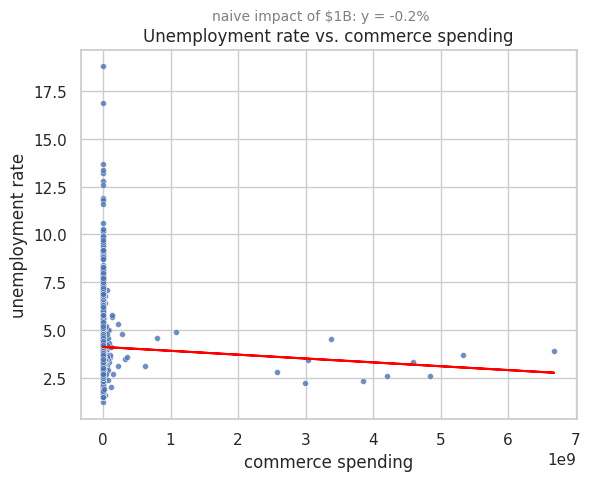

In [4]:
regression_line = np.polyfit(int_data, out_data, 1)
regression_fn = np.poly1d(regression_line)
line_values = regression_fn(int_data)
line_equation = f"naive impact of $1B: y = {round(regression_line[0] * 1e9, 2)}%"

sns.set(style="whitegrid")
sns.scatterplot(x=int_data, y=out_data, alpha=0.8, s=18)
plt.plot(int_data, line_values, color="red")
plt.suptitle(line_equation, y=0.95, fontsize=10, ha="center", va="center", color="gray")

plt.xlabel("commerce spending")
plt.ylabel("unemployment rate")
plt.title("Unemployment rate vs. commerce spending")

plt.legend().set_visible(False)
plt.show()

You visual/linear-model-based intuitions might be two-fold. 
1) You would expect on average a drop of .45% between the groups, perhaps expecting a drop of .2% per 1B funding.
2) You might think that while the average drop isn't huge, it seems that receiving the funding protects places from really bad outcomes, as you notice that no county in the funded group had unemployment above 5.8.

The question is, even if this insight is right (spoiler: it isn't), what does it tell you about whether Northwest Arctic Borough should fight (or should've fought) for such funding? In 2016 the unemployment rate there was 12.8% - so, which is it, should you expect a drop of, say, .6% if you get around $3B funding, or should you expect to be protected from the extreme outcomes and hope for an outcome closer to 6%?

There are, however, reasons to think that this is a bit too hasty. The key problem is that neither U.S. Department of Commerce funding, nor unemployment arise in vacuum. For one thing, obviously, various covariates should be paid attention to, and their use might lead to more precise predictions that would take the specific circumstances of this county into consideration. The problem is deeper though: the protection effect that you think you see might simply arise because the places with high unemployment are under-staffed, under-funded or for some reasons ineligible for the department of commerce funding. The problem then is that the funded places more or less self-selected because some of their covariates caused the unfunded places to remain unfunded. You need to pay attention not only to covariates but also to the causal structure of the problem. This is what our model does, insofar as general application to all intput-output combinations permits.

For one thing, we divide all features into intervention time series, outcome time series and covariates, which are usually either average data from a few years or data that were only available from a particular point in time but are not expected to change in time very much (see your data guide for details). Our models use the covariates as well.

In [5]:
features = list_available_features()
tensed_features = list_tensed_features()
interventions = list_interventions()
outcomes = list_outcomes()

covariates = [var for var in list_available_features() if var not in tensed_features]

print("covariates:", covariates)
print("interventions:", interventions)
print("outcomes", outcomes)

covariates: ['age_composition', 'burdens_energy', 'burdens_housing', 'diesel_matter_exposure', 'ethnic_composition', 'expected_agricultural_loss_rate', 'expected_building_loss_rate', 'expected_population_loss_rate', 'hazard', 'homeownership_rate', 'income_distribution', 'industry', 'median_owner_occupied_home_value', 'median_rent', 'proximity_to_hazardous_waste_sites', 'proximity_to_risk_management_plan_facilities', 'transport', 'urbanization']
interventions: ['spending_HHS', 'spending_commerce', 'spending_transportation']
outcomes ['gdp', 'industry_accommodation_food_services_total', 'industry_admin_support_services_total', 'industry_agriculture_total', 'industry_arts_recreation_total', 'industry_construction_total', 'industry_educational_services_total', 'industry_finance_insurance_total', 'industry_healthcare_social_services_total', 'industry_information_total', 'industry_management_enterprises_total', 'industry_manufacturing_total', 'industry_mining_total', 'industry_other_services

For another, the model (which can be found in `cities.modeling.model_interactions`) assumes a causal structure typical for [structured latent confounders models](https://proceedings.mlr.press/v119/witty20a.html), where:

1) covariates can have causal impact on the interventions and on the outcomes,
2) intervention can have causal impact on the outcome
3) there are two latent confounders, state, and year, whereby we assume that there are unobserved state- and year-level variables which make the way things develop within states or within the same year more similar.


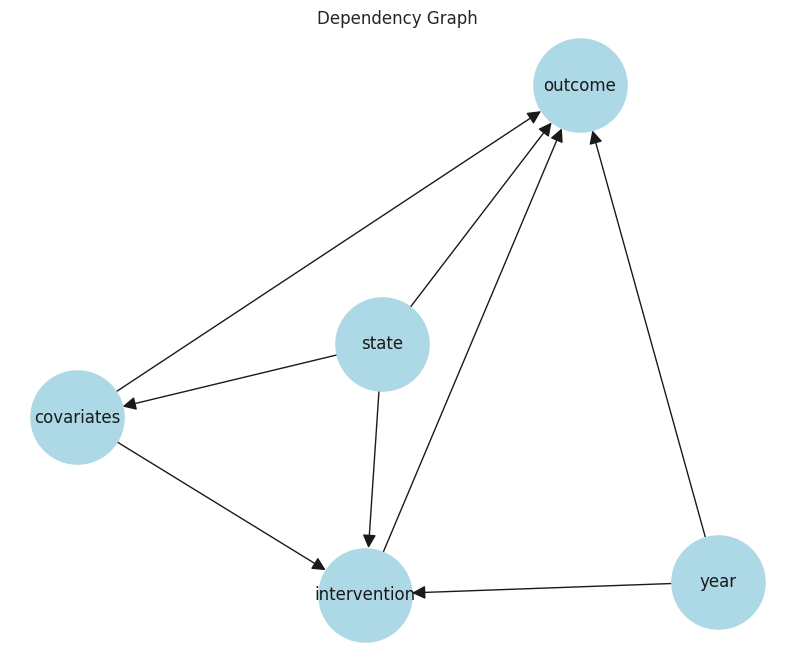

In [6]:
G = nx.DiGraph()
nodes = ["covariates", "intervention", "outcome", "state", "year"]
G.add_nodes_from(nodes)
edges = [
    ("covariates", "intervention"),
    ("covariates", "outcome"),
    ("intervention", "outcome"),
    ("state", "covariates"),
    ("state", "intervention"),
    ("state", "outcome"),
    ("year", "intervention"),
    ("year", "outcome"),
]

G.add_edges_from(edges)
fig, ax = plt.subplots(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=4500, node_color="lightblue", arrowsize=20)
plt.title("Dependency Graph")
plt.show()


For the sake of interpretability and to not make the model too complicated for its own good, we assume the dependencies involved are linear.

We also assume slighty regularizing priors for the coefficients, with normal distributions centered at 0 and standard deviations .9.

We do not assume any linearity or trend in years. In fact, we line up intervention data with outome data at three different shifts (+1, +2, +3 time units forward) and train the models meant to predict these separately. We also do not assume any constraints between years, effectively assuming the impacts of particular years are not informed by the impact of previous years - this is our effort to be conservative and build relatively little theory into the model.

This allows us, in counterfaction post-dictions (that is, predictions of what would have happened under a different intervention), to stop the flux of information upstream causal arrows and to isolate the uncertainty about the causal impact from the uncertainties involving the impact other phenomena (after all, we already know what did happen between 2016 and 2019).

Now, let's see what our trained model says about the county of interest. 

In [7]:
ci = CausalInsight(
    outcome_dataset=outcome,
    intervention_dataset=intervention,
    num_samples=1000,
)

percent_calc = ci.slider_values_to_interventions(intervened_percent=45, year=2016)
ci.get_tau_samples()

fips = 6025  # 2188
ci.get_fips_predictions(
    intervened_value=percent_calc["intervened_transformed"], fips=fips, year=2016
)

display(ci.predictions_original)

ci.plot_predictions(range_multiplier=1, scaling="original")

,year,observed,mean,low,high
2016,2016,24.2,24.2,24.2,24.2
2017,2017,19.7,18.520342,17.716211,19.459003
2018,2018,18.8,17.467766,16.659423,18.46296
2019,2019,20.7,18.389801,17.338502,19.864349


Recall now our original question inspired by the initial and misleading data visualisation. Recall that our question was, *which is it, should you expect a drop of 
.6% if you get around $3B funding, or should you expect to be protected from the extreme outcomes and hope for an outcome closer to 6%?*

The more causally aware our models offer is that neither answer is correct. On one hand, there are some confunding factors that lead to self-selection of funded counties, so the latter belief would be overly optimistic. On the other hand, you should also expect a slightly higher difference, that of 1.2% rather than .6%.